In [2]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import time

# Homework 3: Neural Networks

Please read all instructions for this homework carefully. Many of the questions ask for specific things to be in your notebooks and many of your questions may be answered in the step-by-step instructions. You will need include _all_ parts of the questions in your answers to recieve full credit.

This homework is going to focus heavily on the practical use of neural networks. You will be required to learn the basics of PyTorch (https://pytorch.org/) to implement and train fully connected and convolutional neural networks.

We strongly recommend working through the PyTorch beginner guide [here](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html), which will both give you a good idea of how PyTorch works and provide you with some boilerplate code you can adapt for this assignment. 

## Question 3: Backpropagation

A computational graph is a framework to represent complex mathematical expressions as a directed graph of function compositions, starting from the simplest, to the most complex. For instance, the expression $e = (a+b)\times(b+1)$ can be represented as a computational graph, as shown in the figure below. Each node represents a variable, where the direction represents the flow of inputs to (intermediate) outputs. All incoming variables are collected to be operated on by a function. 

$$
c = a + b \\
d = b + 1 \\
e = c \times d
$$


In the graph below, these functions are multiplications and additions, and a sequence of simple operations leads to the relatively complex expression of $e$.

![A Computational Graph (http://colah.github.io/posts/2015-08-Backprop/)](http://colah.github.io/posts/2015-08-Backprop/img/tree-def.png)

Computational graphs allow for a computational abstraction to compute _exact_ partial derivatives of complex expressions, as a realization of the chain rule from calculus. For instance, computing $\frac{\partial e}{\partial a}$ involves essentially reversing the arrows and transporting intermediate partial derivatives back to $a$. This method is termed _backpropagation_ (short: _backprop_), and is a key ingredient of modern neural network frameworks that implement gradient descent (including PyTorch). The first-three sections of [Calculus on Computational Graphs: Backpropagation](http://colah.github.io/posts/2015-08-Backprop/) should allow reasonable understanding for the next questions.

### Part A: Computational Graph for Logistic Regression

Build the computational graph of logistic regression for a single input/output pair. As in earlier homeworks/labs, use the variables $\mathbf{w} = \begin{bmatrix}\mathbf{w}_0 & \mathbf{w}_1 & \cdots & \mathbf{w}_d\end{bmatrix}^T \in \mathbb{R}^{d+1}$ for the vector of parameters and $\mathbf{x} = \begin{bmatrix}1 & x_1 & x_2 & \cdots & x_d \end{bmatrix} \in \mathbb{R}^{d}$ for the vector input, with $y$ as the corresponding output. Write the computational graph as a sequence of algebraic equations in terms of simple unary/binary functions only (no graphic needed).

**Answer Here:** 

A simple logistic regression modeled as a computational graph of primitive functions would be 

$ z = \mathbf{w}^T\mathbf{x} $ as the first node and $y = \sigma(z), y^* = 1-\sigma(z)$ 
as the network outputs

### Part B: Backprop on Logistic Regression

For the computational graph built in I., compute the derivatives of the loss in logistic regression with respect to the parameters $\mathbf{w}$ via backpropagation. Write these as a sequence of equations (no graphic needed), that clearly show _backward_ flow of gradients via the chain rule.

**Hint**: Table 3 of [this manuscript](https://arxiv.org/abs/1502.05767) may be a helpful resource.

**Answer Here:** 


Assuming standard Binary Cross Entropy Loss we have 

$$E(\mathbf{w}) = \sum_{i=1}^{N} t_i\log\sigma({\mathbf{w}^T\mathbf{x}}) + (1-t_i)\sigma(-\mathbf{w}^T\mathbf{x})$$
The first thing we need is to compute the derivative of the Error with respect to our predicted output $y$ and $y^*$. 
$$E(\mathbf{w}) = \sum_{i=1}^{N} t_i\log y_i +(1-t_i)\log(y^*)$$
$$\frac{\partial E}{\partial y} =  \sum_{i=1}^N \frac{t_i}{y_i}$$
$$\frac{\partial E}{\partial y*} = -\sum_{i=1}^{N}\frac{1-t_i}{y*}$$
Then we want to evaluate the derivative of y with respect to z.
$$\frac{\partial y}{\partial z}=\sigma(z)( 1-\sigma(z))$$
$$\frac{\partial y^*}{\partial z} = -\sigma(z)(1-\sigma(z))$$
and finally the derivative of z with respect to w
$$\frac{\partial{z}}{\partial \mathbf{w}} = \mathbf{x}$$

### Part C: Challenges in _deep_ neural networks

Now consider a _deep_ neural network with L layers, such that the function is defined via weight matrices at each layer are defined as $W^{(l)}$ for all $l \in [1, \dots, L]$, along with $\sigma$ (sigmoid) non-linearity which is applied pointwise to the activation $h^{(l)}$ of each layer.

$$
h^{(l)} = \begin{cases}
\sigma(W^{(l)}\mathbf{x}),\quad\quad\text{if}~l = 1 \\
\sigma(W^{(l)}h^{(l-1)}),\quad\text{if}~l < L \\
W^{(l)}h^{(l-1)},\quad\quad\text{if}~l = L
\end{cases}
$$

The definition simply defines the operations at the input layer (which involves $\mathbf{x}$), hidden layers (which only involve activations at the previous layer $h^{(l-1)}$), and the output layer where no $\sigma$ (sigmoid) activation is applied. Therefore, the neural network can be recursively defined as $f_\mathbf{w}(h^{(L)})$. Why can very deep networks (i.e. large $L$) with sigmoid non-linearities be hard to learn via backpropagation?

**Hint**: Consider a two hidden layer neural network (i.e. L = 3), and think about how repeated application of chain rule affects the qualitative nature of the gradients as we backpropagate from the output layer to the input layer, as we increase L.

**Answer Here:** 
The sigmoid activation has the property that
$$0 \le \sigma(x) \le 1$$
Further the derivative of $\sigma(x)$ wrt $x$ has the form 
$$\sigma(x)(1-\sigma(x))$$
This derivative always being less than 1 and greater than or equal to 0 back propagation of an error function over many sigmoidal activation function layers would result the product of many values $\in [0,1)$. For large L this means that the early layers become harder and harder to train with the gradient becoming smaller in smaller as L grows.

## Question 2: A Simple Dataset

The aim of this question is to implement a first neural network, and start to get an intuition about what sorts of functions neural networks are capable of producing.
First, use the provided code to generate 1000 training points and 500 testing points from the _two spirals_ dataset with `noise=1.5`.


**Note** We've also included a two functions to help you. You should _not_ alter these functions (nor should you need to).

`plotter` takes in your model and the training and testing data and will plot the predictions generated by your neural network.

`accuracy` is a simple function that will compute the accuracy of your model on some given `x` and `y` data, i.e. either `train_x` and `train_y`, or `test_x` and `test_y`. 

In [3]:
def twospirals(n_points, noise=1.5, random_state=42):
    """
     Returns the two spirals dataset.
     Note: n_points is points PER CLASS
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + np.random.randn(n_points,1) * noise
    d1y =  1.5*np.sin(n)*n + np.random.randn(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

ntrain = 1000
ntest = 500
noise = 1.5

train_x, train_y = twospirals(int(ntrain/2), noise=noise)
train_x, train_y = torch.FloatTensor(train_x), torch.FloatTensor(train_y).unsqueeze(-1)

test_x, test_y = twospirals(int(ntest/2), noise=noise)
test_x, test_y = torch.FloatTensor(test_x), torch.FloatTensor(test_y).unsqueeze(-1)

#### Helper Functions

In [4]:
train_x.shape, train_y.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [5]:
def plotter(model, train_x, train_y, test_x, test_y):
    '''
    This is just a simple plotting function, you should NOT need to change anything here
    '''
    buffer = 1.
    h = 0.1
    x_min, x_max = train_x[:, 0].min() - buffer, train_x[:, 0].max() + buffer
    y_min, y_max = train_x[:, 1].min() - buffer, train_x[:, 1].max() + buffer

    xx,yy=np.meshgrid(np.arange(x_min.cpu(), x_max.cpu(), h), 
                      np.arange(y_min.cpu(), y_max.cpu(), h))
    in_grid = torch.FloatTensor([xx.ravel(), yy.ravel()]).t()

    pred = torch.sigmoid(model(in_grid)).detach().reshape(xx.shape)
    plt.figure(figsize=(15, 10))
    cmap = sns.color_palette("crest_r", as_cmap=True)
    plt.contourf(xx, yy, pred, alpha=0.5, cmap=cmap)
    plt.title("Classifier", fontsize=24)
    cbar= plt.colorbar()
    cbar.set_label(label=r"$P(Y = 1)$", size=18)
    cbar.ax.tick_params(labelsize=18)
    plt.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary, alpha=0.5, label="Train")
    plt.scatter(test_x[:, 0].cpu(), test_x[:, 1].cpu(), c=test_y[:, 0].cpu(), cmap=plt.cm.binary, marker='+', s=150, label="Test")
    plt.legend(fontsize=18)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def accuracy(model, X, Y):
    X = X
    preds = torch.round(torch.sigmoid((model(X))))
    return 100 * len(torch.where(preds == Y)[0])/Y.numel()

### Part A: Network Definition

Write a class that defines a _fully connected_ neural network with ReLU activations. Your class should be a child class of the `torch.nn.Module` class, i.e. the first line of your class definition should be something like:
```{python}
class NeuralNetwork(nn.Module):
```
The number of layers and width of each layer is up to you - but keep this implementation flexible, as you'll need to come back and tweak your network in order to achieve the desired accuracy on our dataset.
Additionally, this network should be built to work with the two spirals dataset, meaning it should take 2 dimensional inputs and produce a 1 dimensional output. Specifically we are constructing a network $f(x): \mathbb{R}^2 \rightarrow \mathbb{R}$.

To ensure that your model is correctly defined, the last cell in your notebook for this section should contain the following lines, with the correct handle for your neural network class:

```{python}
model = your_network_class(appropriate_arguments)
print(model(train_x).shape)
```

**Answer Here**

In [6]:
class NeuralNetwork(nn.Module):
  def __init__(self, in_size):
    super().__init__()
    
    self.fc = nn.Sequential(nn.Linear(in_size,60, bias=True),
                            nn.ReLU(),
                            nn.Linear(60,60, bias=True),
                            nn.ReLU(),
                            nn.Linear(60,60, bias=True),
                            nn.ReLU(),
                            nn.Linear(60, 1, bias=True))


  def forward(self, x):
    out = self.fc(x)
    return out
  ## define forward pass





In [7]:
model = NeuralNetwork(in_size=2)
print(model(train_x).shape)

torch.Size([1000, 1])


### Part B: Training

Write and execute code to train your neural network. You should train with SGD, using the `torch.nn.BCEWithLogitsLoss` loss function. Tune your network and training routine until you get **at least 90% training accuracy**. You should think about changing: width and depth of your network, the learning rate of your optimizer, the number of training iterations, and including bias terms in your network layers.

After your model is trained plot the predicted function using the `plotter` function. Report the _test_ accuracy achieved by your model as well as the architecture of your network - how many layers did you use, how wide was each layer, did you include a bias term, etc.


**Note**: with the right network setup you can achieve this training accuracy in less than 5 seconds on a laptop, you can use a large model that takes longer to train if you want, but be advised that you don't _need_ a large model to be successful here. 

**Answer Here**

In [8]:
%%time
net = NeuralNetwork(in_size=train_x.shape[1])
optim = torch.optim.SGD(net.parameters(), lr=1e-1)
ell = nn.BCEWithLogitsLoss()
epochs = 3000
# net.train()
loss_trace = []
for e in range(epochs):
  optim.zero_grad()
  p_y = net(train_x)
  loss = ell(p_y, train_y.float())
  
  loss_trace.append(loss.detach().item())
  if(e+1) % 50 == 0:
        print(f'[Epoch {e + 1}] Loss: {loss_trace[-1]}')
  loss.backward()
  optim.step()

[Epoch 50] Loss: 0.601934552192688
[Epoch 100] Loss: 0.5969321131706238
[Epoch 150] Loss: 0.5933103561401367
[Epoch 200] Loss: 0.5895847678184509
[Epoch 250] Loss: 0.5851700305938721
[Epoch 300] Loss: 0.5798675417900085
[Epoch 350] Loss: 0.5783063173294067
[Epoch 400] Loss: 0.5726710557937622
[Epoch 450] Loss: 0.5631793737411499
[Epoch 500] Loss: 0.5556540489196777
[Epoch 550] Loss: 0.5428696870803833
[Epoch 600] Loss: 0.5274555087089539
[Epoch 650] Loss: 0.5037215352058411
[Epoch 700] Loss: 0.5000870227813721
[Epoch 750] Loss: 0.46148255467414856
[Epoch 800] Loss: 0.4629059433937073
[Epoch 850] Loss: 0.4824329912662506
[Epoch 900] Loss: 0.45729634165763855
[Epoch 950] Loss: 0.47025856375694275
[Epoch 1000] Loss: 0.440432071685791
[Epoch 1050] Loss: 0.41191551089286804
[Epoch 1100] Loss: 0.40794670581817627
[Epoch 1150] Loss: 0.37742406129837036
[Epoch 1200] Loss: 0.4362446367740631
[Epoch 1250] Loss: 0.36083734035491943
[Epoch 1300] Loss: 0.32203900814056396
[Epoch 1350] Loss: 0.30737

In [9]:
accuracy(net, train_x, train_y), accuracy(net, test_x, test_y)


(92.5, 92.4)

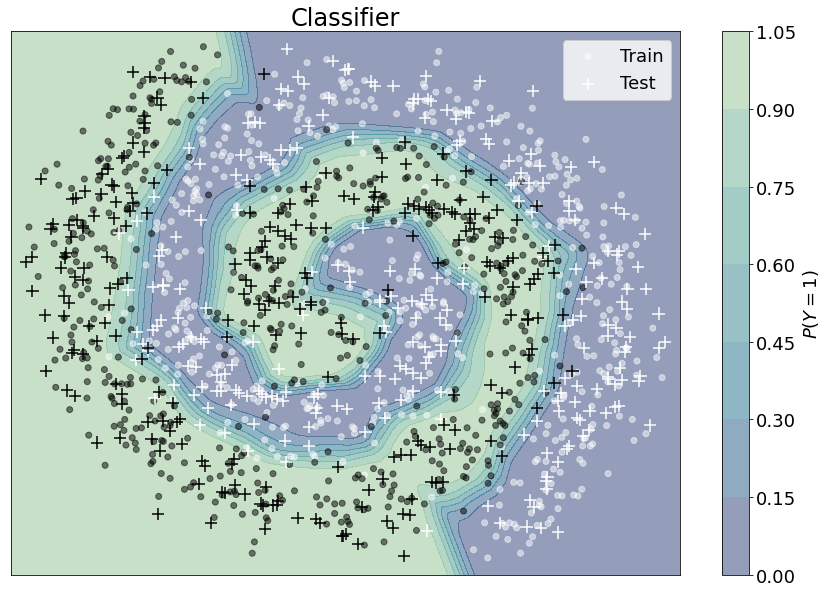

In [10]:
plotter(net, train_x, train_y, test_x, test_y)

I build a NN with 3 hidden layers. Each linear layer used a width of 60 nodes and used a bias term. ReLU activation functions where used at every hidden layer and the network was trained for 3000 epochs with a learning rate of 1e-1. Test accuracy was 88.4%.

## Question 3: Convolutional Networks and Image Recognition

In this question we are going to build up to larger models on larger datasets. If you don't already have access to a CUDA-enabled GPU you will need to complete this section of the homework on Google Colab. Google Colab allows you to run hardware accelerated notebooks online for free. By uploading this notebook into Colab then selecting `Runtime` -> `Change Runtime Type` -> And choosing `GPU` as your hardware accelerator you will be able to run your code on a GPU.

Before starting we need to setup our data. We'll use the `torchvision` package to handle sourcing and normalizing the CIFAR-10 dataset, which we'll need to download to continue.

In [11]:
import torchvision
import torchvision.transforms as transforms

The code cell below sets up a data transformation which casts the data to tensors (so we can pass it through a network), and normalizes each of the 3 RGB layers of the images. The first time you run this you will see a progress bar showing that the dataset is being downloaded. 

After running this code you will have a `trainloader` and a `testloader`. These are iterable python objects that allow you to sample mini-batches of data according the `batch_size` you passed in to the `DataLoader` function call. You can loop through the full dataset by running:
```{python}
for inputs, targets in trainloader:
    ...
```

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2,
                                          pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2,
                                         pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
trainloader.batch_size

128

## Part A: Network Definition

A common strategy for defining convolutional neural networks is to first pass the data through a set of convolutional layers to perform feature extraction, then to pass through a set of linear, or fully connected, layers to perform classification. 

Construct a class that defines a pytorch model to be used with CIFAR-10 containing the following layers, in order:

- A convolutional layer outputting 8 channels with a kernel size of 3
- A ReLU activation
- A max-pooling layer with kernel size of 2
- A convolutional layer outputting 16 channels with a kernel size of 3
- A ReLU activation
- A max-pooling layer with kernel size of 2
- A convolutional layer outputting 32 channels with a kernel size of 3
- A ReLU activation
- A max-pooling layer with kernel size of 2
  - After this operation you will need to reshape the outputs of the max-pooling layer to a tensor of size `batch_size` $\times$ `128`
- A linear layer with an output size of 128
- A ReLU activation
- A linear layer with an output size of 64
- A ReLU activation
- A linear layer with an output size of 10



To show that your network is correctly implemented, after you define this class, create an instance of it and show that if you pass a batch of CIFAR-10 images from `trainloader` through the network you get an output of size `batch_size` $\times$ `10`.

**Answer Here**

In [14]:
class ImageClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(nn.Conv2d(3, 8, 3),
                            nn.ReLU(),
                            nn.MaxPool2d(2),
                            nn.Conv2d(8, 16, 3),
                            nn.ReLU(),
                            nn.MaxPool2d(2),
                            nn.Conv2d(16, 32, 3),
                            nn.ReLU(),
                            nn.MaxPool2d(2)                            )
    
    self.classifier = nn.Sequential(nn.Linear(128, 128, bias = True),
                            nn.ReLU(),
                            nn.Linear(128, 64, bias=True),
                            nn.ReLU(),
                            nn.Linear(64, 10, bias=True)
                            )
    
  def forward(self, train):

    x = self.features(train)
    x = torch.reshape(x, (train.shape[0], 128))
    x = self.classifier(x)
    return x
                          
                          



In [15]:
conv = ImageClassifier()
for train, test in trainloader:
  print(conv(train).shape)
  break

torch.Size([128, 10])


/home/carpfire/anaconda3/envs/machine_learning/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [17]:
conv(train).argmax(1)

tensor([6, 9, 6, 9, 6, 0, 9, 1, 5, 0, 0, 1, 6, 8, 6, 9, 6, 6, 6, 1, 5, 5, 6, 8,
        6, 6, 8, 6, 8, 6, 0, 7, 0, 0, 9, 0, 7, 6, 9, 8, 9, 1, 1, 6, 8, 0, 6, 0,
        7, 9, 1, 7, 0, 8, 0, 1, 6, 9, 7, 5, 9, 6, 3, 1, 7, 6, 4, 7, 6, 0, 3, 6,
        8, 8, 0, 7, 7, 6, 6, 1])

## Part B: Training Loop

Using `torch.nn.CrossEntropyLoss` as your objective function and `torch.optim.SGD` as your optimizer. Train your network for 2 epochs while running on a _CPU_ using a batch size of 128. How long does it take? 

**Answer Here**

In [16]:
%%time
conv = ImageClassifier()
opt = torch.optim.SGD(conv.parameters(), lr= 1e-1)
ell = torch.nn.CrossEntropyLoss()
epochs = 2
loss_trace = []
for e in range(epochs):
  for train, target in trainloader:
    opt.zero_grad()
    p_y = conv(train)
    loss = ell(p_y, target)
    loss_trace.append(loss.detach().item())      
    loss.backward()
    opt.step()
  print(f'[Epoch {e + 1}] Loss: {loss_trace[-1]}')


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 1] Loss: 2.243412494659424


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 2] Loss: 1.8718922138214111
CPU times: user 1min 16s, sys: 2.26 s, total: 1min 18s
Wall time: 10.1 s


Took us a minute, or rather 28.4 seconds.

## Part C: Porting to a GPU

CUDA-enabled GPUs can speed up training time signficantly, and have really enabled the widespread success of neural networks. Using a GPU, reinitialize your network and train for 2 epochs using a batch size of 128. How long does 2 epochs of training take? If you are correctly utilizing a GPU a single epoch should take only about 50-60% as much time as in Part B. 

To be sure you are doing things correctly: if you have a torch tensor, `X`, you can see what device it is on using the command `X.device`; if the tensor is stored on the GPU you will see `type='cuda'` in the output.

**Answer Here**

In [18]:
%%time
device = torch.device("cuda:0")
conv = ImageClassifier().to(device)
opt = torch.optim.SGD(conv.parameters(), lr= 1e-1)
ell = torch.nn.CrossEntropyLoss()
epochs = 2
loss_trace = []
for e in range(epochs):
  for train, target in trainloader:
    opt.zero_grad()
    p_y = conv(train.to(device))
    loss = ell(p_y, target.to(device))
    loss_trace.append(loss.detach().item())      
    loss.backward()
    opt.step()
  print(f'[Epoch {e + 1}] Loss: {loss_trace[-1]}')


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 1] Loss: 2.2926621437072754


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 2] Loss: 1.8238227367401123
CPU times: user 6.8 s, sys: 1.3 s, total: 8.1 s
Wall time: 8.74 s


Two epochs of training takes 19 seconds. 

## Part D: Training Your Network

Now you're going to fully train your network on CIFAR-10. Using SGD with a learning rate of 0.01 and a momentum parameter of 0.9 train your network for 30 epochs using a GPU. 

You should log the training accuracy and average loss per training input at every epoch, and test accuracy and average loss per test input every other epoch. Make sure that you are **not** training the network when evaluating the performance on testing data. 

If you have constructed your network and your training loop correctly training your network should take about 5-10 minutes, including the evaluation on the test data. If it is taking significantly longer than that make sure that you are utilizing the GPU correctly, and that you are not doing any redundant computations in your code. 

**Answer Here**

In [19]:
def accuracy(model, loader):
    acc = 0
    samples = 0
    for train, target in loader:
      train, target = train.cuda(), target.cuda()
      with torch.no_grad():
        pred = model(train).argmax(1)
        correct = torch.where(pred == target)[0]
        acc += correct.size(0)
        samples += target.size(0)
    return acc/samples


In [20]:
def test_loss(model, loader, trace, loss):
  samples = 0
  for data, target in loader:
    data, target = data.cuda(), target.cuda()
    with torch.no_grad():
      samples += data.size(0)
      pred = model(data)
      l = loss(pred, target)
      trace.append(l.detach().item())
  return samples
    

In [21]:

device = torch.device("cuda:0")
conv = ImageClassifier().to(device)
opt = torch.optim.SGD(conv.parameters(), lr= 1e-2, momentum=.9)
ell = torch.nn.CrossEntropyLoss()
epochs = 30
train_loss_trace_og= []
test_loss_trace_og = []
train_trace_og = []
test_trace_og = []

for e in range(epochs):
  train_size = 0
  for train, target in trainloader:
    opt.zero_grad()
    p_y = conv(train.to(device))
    train_size += train.size(0)
    loss = ell(p_y, target.to(device))
    train_loss_trace_og.append(loss.detach().item())      
    loss.backward()
    opt.step()
  test_size = test_loss(conv, testloader, test_loss_trace_og, ell)
  print(f'[Epoch {e + 1}] Average Test Loss: {test_loss_trace_og[-1]/test_size}')
  print(f'[Epoch {e + 1}] Average Loss: {train_loss_trace_og[-1]/train_size}')
  train_acc = accuracy(conv, trainloader)
  train_trace_og.append(train_acc)  
  print(f'[Epoch {e + 1}] Train Accuracy :{train_acc}')
  if e%2 == 0:
    test_acc = accuracy(conv, testloader)
    test_trace_og.append(test_acc)
    print(f'[Epoch {e + 1}] Test Accuracy :{test_acc}')

  

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 1] Average Test Loss: 0.00018749762773513794
[Epoch 1] Average Loss: 4.287433624267578e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 1] Train Accuracy :0.20328


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 1] Test Accuracy :0.2084


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 2] Average Test Loss: 0.00015350055694580078
[Epoch 2] Average Loss: 3.5550274848937985e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 2] Train Accuracy :0.36056


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 3] Average Test Loss: 0.0001565809965133667
[Epoch 3] Average Loss: 2.636343717575073e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 3] Train Accuracy :0.45706


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 3] Test Accuracy :0.4595


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 4] Average Test Loss: 0.0001282389760017395
[Epoch 4] Average Loss: 2.7118821144104004e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 4] Train Accuracy :0.51142


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 5] Average Test Loss: 0.00014279870986938476
[Epoch 5] Average Loss: 1.9448373317718506e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 5] Train Accuracy :0.5505


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 5] Test Accuracy :0.5412


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 6] Average Test Loss: 0.00011795449256896973
[Epoch 6] Average Loss: 2.4879937171936036e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 6] Train Accuracy :0.59798


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 7] Average Test Loss: 0.00010981131792068481
[Epoch 7] Average Loss: 2.431384801864624e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 7] Train Accuracy :0.6147


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 7] Test Accuracy :0.6005


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 8] Average Test Loss: 0.00010115679502487183
[Epoch 8] Average Loss: 1.9759525060653686e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 8] Train Accuracy :0.63624


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 9] Average Test Loss: 0.00010883156061172485
[Epoch 9] Average Loss: 2.076683282852173e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 9] Train Accuracy :0.65436


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 9] Test Accuracy :0.6247


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 10] Average Test Loss: 8.307967185974122e-05
[Epoch 10] Average Loss: 1.9069191217422484e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 10] Train Accuracy :0.67094


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 11] Average Test Loss: 6.820722818374633e-05
[Epoch 11] Average Loss: 2.4320051670074463e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 11] Train Accuracy :0.65084


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 11] Test Accuracy :0.6108


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 12] Average Test Loss: 0.00010391998291015625
[Epoch 12] Average Loss: 2.3575143814086915e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 12] Train Accuracy :0.66288


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 13] Average Test Loss: 0.00010050017833709717
[Epoch 13] Average Loss: 1.914940118789673e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 13] Train Accuracy :0.7031


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 13] Test Accuracy :0.6551


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 14] Average Test Loss: 9.668222665786744e-05
[Epoch 14] Average Loss: 2.111037492752075e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 14] Train Accuracy :0.70292


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 15] Average Test Loss: 0.00010298529863357543
[Epoch 15] Average Loss: 1.4493513107299804e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 15] Train Accuracy :0.69844


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 15] Test Accuracy :0.6448


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 16] Average Test Loss: 8.945125341415405e-05
[Epoch 16] Average Loss: 1.680871367454529e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 16] Train Accuracy :0.71046


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 17] Average Test Loss: 0.00010057129859924316
[Epoch 17] Average Loss: 1.7375484704971315e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 17] Train Accuracy :0.72888


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 17] Test Accuracy :0.6613


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 18] Average Test Loss: 9.7963547706604e-05
[Epoch 18] Average Loss: 1.4627296924591064e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 18] Train Accuracy :0.73186


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 19] Average Test Loss: 8.796430230140686e-05
[Epoch 19] Average Loss: 1.40700364112854e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 19] Train Accuracy :0.74436


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 19] Test Accuracy :0.6706


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 20] Average Test Loss: 8.724387288093567e-05
[Epoch 20] Average Loss: 1.7252652645111084e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 20] Train Accuracy :0.73716


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 21] Average Test Loss: 6.570705771446228e-05
[Epoch 21] Average Loss: 1.5121893882751465e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 21] Train Accuracy :0.75238


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 21] Test Accuracy :0.6653


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 22] Average Test Loss: 7.87692129611969e-05
[Epoch 22] Average Loss: 1.6823594570159913e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 22] Train Accuracy :0.73302


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 23] Average Test Loss: 8.629263639450073e-05
[Epoch 23] Average Loss: 1.5142958164215088e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 23] Train Accuracy :0.7565


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 23] Test Accuracy :0.6597


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 24] Average Test Loss: 5.9807664155960085e-05
[Epoch 24] Average Loss: 1.3214209079742432e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 24] Train Accuracy :0.75846


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 25] Average Test Loss: 9.495642185211181e-05
[Epoch 25] Average Loss: 1.2620755434036255e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 25] Train Accuracy :0.767


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 25] Test Accuracy :0.6702


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 26] Average Test Loss: 7.328073382377624e-05
[Epoch 26] Average Loss: 1.2885891199111938e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 26] Train Accuracy :0.76278


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 27] Average Test Loss: 9.206298589706421e-05
[Epoch 27] Average Loss: 1.425398588180542e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 27] Train Accuracy :0.76932


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 27] Test Accuracy :0.6664


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 28] Average Test Loss: 7.530000805854797e-05
[Epoch 28] Average Loss: 1.4599373340606689e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 28] Train Accuracy :0.7616


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 29] Average Test Loss: 9.886900782585144e-05
[Epoch 29] Average Loss: 1.447777509689331e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 29] Train Accuracy :0.78076


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 29] Test Accuracy :0.6643


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 30] Average Test Loss: 9.894325137138366e-05
[Epoch 30] Average Loss: 1.2980327606201172e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 30] Train Accuracy :0.75066


## Part E: Examining Your Results

Take the stored training and testing evaluations from the previous question and make two plots:
  1. A plot of loss vs. time including curves for both training and testing,
  2. A plot of accuracy vs. time including curves for both training and testing.

You should see the gap between the performance of your model start to increase as training progresses. This gap is referred to as the _generalization gap_. Why do you think the generalization gap grows later in training, and why might this be an issue for neural networks specifically.


Please use the following function to compute the accuracy of your trained network - you should **not** need to modify this function.

In [22]:
def cifar_accuracy(net, loader):
    acc = 0
    total_num = 0
    for inputs, labels in loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        total_num += inputs.shape[0]
        with torch.no_grad():
            outputs = net(inputs)

            _, predicted = torch.max(outputs.data, 1)
            acc += (predicted == labels).sum().item()

    return acc/total_num


**Answer Here**

In [23]:
len(test_loss_trace_og)

2370

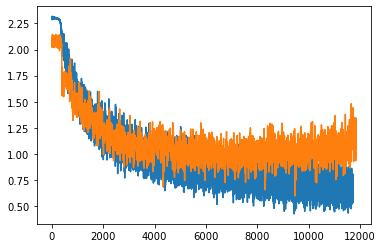

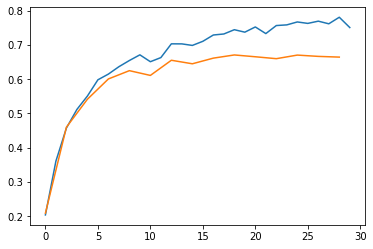

In [24]:
plt.figure()
plt.plot(train_loss_trace_og)
plt.plot(range(0, 2370*5,5),test_loss_trace_og)
plt.figure()
plt.plot(train_trace_og)
plt.plot(range(0, 30, 2), test_trace_og)
plt.show()

## Part F: Closing the generalization gap

Re-initialize and re-train your CNN in a way that will reduce the overall generalization gap. There are a lot of ways you can do this, including writing your own custom loss function to use, or simply making the right modifications to the optimizer you are using. 

Again make the following two plots:
  1. A plot of loss vs. time including curves for both training and testing,
  2. A plot of accuracy vs. time including curves for both training and testing.

What do you observe?

A note: you may not see dramatic improvement here, because we are using a fairly small model, however this type of thinking and the problem of closing the generalization gap is an important consideration in how we train very large state of the art models.

**Answer Here**

In [25]:

device = torch.device("cuda:0")
conv = ImageClassifier().to(device)
opt = torch.optim.SGD(conv.parameters(), lr= 1e-2, momentum=.9, weight_decay=.003)
ell = torch.nn.CrossEntropyLoss()
epochs = 30
train_loss_trace_tune = []
test_loss_trace_tune = []
train_trace_tune = []
test_trace_tune = []
for e in range(epochs):
  train_size = 0
  for train, target in trainloader:
    opt.zero_grad()
    train_size += train.size(0)
    p_y = conv(train.to(device))
    loss = ell(p_y, target.to(device))
    train_loss_trace_tune.append(loss.detach().item())      
    loss.backward()
    opt.step()
  test_size = test_loss(conv, testloader, test_loss_trace_tune, ell)
  print(f'[Epoch {e + 1}]Average Test Loss: {test_loss_trace_tune[-1]/test_size}')
  print(f'[Epoch {e + 1}]Average Train Loss: {train_loss_trace_tune[-1]/train_size}')
  train_acc = accuracy(conv, trainloader)
  train_trace_tune.append(train_acc)
  print(f'[Epoch {e + 1}] Train Accuracy :{train_acc}')    
  if e%2 == 0:
    test_acc = accuracy(conv, testloader)
    test_trace_tune.append(test_acc)
    print(f'[Epoch {e + 1}] Test Accuracy :{test_acc}')
  

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 1]Average Test Loss: 0.0001978595733642578
[Epoch 1]Average Train Loss: 4.3362774848937985e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 1] Train Accuracy :0.17284


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 1] Test Accuracy :0.1678


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 2]Average Test Loss: 0.00015655156373977662
[Epoch 2]Average Train Loss: 3.897901058197022e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 2] Train Accuracy :0.33414


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 3]Average Test Loss: 0.0001323152780532837
[Epoch 3]Average Train Loss: 3.093945741653442e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 3] Train Accuracy :0.408


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 3] Test Accuracy :0.4038


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 4]Average Test Loss: 0.0001323588490486145
[Epoch 4]Average Train Loss: 2.784353256225586e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 4] Train Accuracy :0.47082


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 5]Average Test Loss: 0.00012135728597640991
[Epoch 5]Average Train Loss: 2.8606131076812744e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 5] Train Accuracy :0.49918


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 5] Test Accuracy :0.4888


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 6]Average Test Loss: 0.000130207097530365
[Epoch 6]Average Train Loss: 2.5286200046539306e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 6] Train Accuracy :0.5456


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 7]Average Test Loss: 0.00013431403636932372
[Epoch 7]Average Train Loss: 2.2256145477294922e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 7] Train Accuracy :0.56384


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 7] Test Accuracy :0.5491


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 8]Average Test Loss: 0.00013417794704437256
[Epoch 8]Average Train Loss: 2.311849355697632e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 8] Train Accuracy :0.58506


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 9]Average Test Loss: 0.00012165166139602662
[Epoch 9]Average Train Loss: 2.240326404571533e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 9] Train Accuracy :0.59548


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 9] Test Accuracy :0.5784


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 10]Average Test Loss: 0.00011707619428634644
[Epoch 10]Average Train Loss: 2.410583734512329e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 10] Train Accuracy :0.5943


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 11]Average Test Loss: 0.00011222013235092164
[Epoch 11]Average Train Loss: 2.427335739135742e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 11] Train Accuracy :0.62682


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 11] Test Accuracy :0.6075


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 12]Average Test Loss: 9.163345098495483e-05
[Epoch 12]Average Train Loss: 1.7381356954574584e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 12] Train Accuracy :0.62696


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 13]Average Test Loss: 0.00011929622888565063
[Epoch 13]Average Train Loss: 2.1637516021728517e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 13] Train Accuracy :0.5989


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 13] Test Accuracy :0.5848


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 14]Average Test Loss: 0.00011827248334884643
[Epoch 14]Average Train Loss: 1.8205101490020753e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 14] Train Accuracy :0.64692


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 15]Average Test Loss: 9.303855895996094e-05
[Epoch 15]Average Train Loss: 2.230046272277832e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 15] Train Accuracy :0.6499


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 15] Test Accuracy :0.6205


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 16]Average Test Loss: 0.00010552818775177002
[Epoch 16]Average Train Loss: 1.5744009017944337e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 16] Train Accuracy :0.6667


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 17]Average Test Loss: 8.750168085098266e-05
[Epoch 17]Average Train Loss: 2.1792469024658203e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 17] Train Accuracy :0.66424


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 17] Test Accuracy :0.6347


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 18]Average Test Loss: 9.29408073425293e-05
[Epoch 18]Average Train Loss: 2.0297176837921143e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 18] Train Accuracy :0.66658


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 19]Average Test Loss: 0.00011532566547393798
[Epoch 19]Average Train Loss: 1.968024253845215e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 19] Train Accuracy :0.68844


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 19] Test Accuracy :0.6514


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 20]Average Test Loss: 9.23904836177826e-05
[Epoch 20]Average Train Loss: 1.990694046020508e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 20] Train Accuracy :0.67758


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 21]Average Test Loss: 0.00011927311420440674
[Epoch 21]Average Train Loss: 1.7909796237945556e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 21] Train Accuracy :0.67928


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 21] Test Accuracy :0.6446


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 22]Average Test Loss: 0.00012562601566314696
[Epoch 22]Average Train Loss: 1.74240243434906e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 22] Train Accuracy :0.67232


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 23]Average Test Loss: 7.578487992286682e-05
[Epoch 23]Average Train Loss: 1.6919867992401125e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 23] Train Accuracy :0.70366


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 23] Test Accuracy :0.6634


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 24]Average Test Loss: 8.68570864200592e-05
[Epoch 24]Average Train Loss: 1.8120691776275636e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 24] Train Accuracy :0.71106


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 25]Average Test Loss: 0.00010431602001190185
[Epoch 25]Average Train Loss: 1.2166290283203125e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 25] Train Accuracy :0.69032


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 25] Test Accuracy :0.6555


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 26]Average Test Loss: 0.00011389129161834717
[Epoch 26]Average Train Loss: 1.2595639228820801e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 26] Train Accuracy :0.70866


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 27]Average Test Loss: 0.00010615464448928833
[Epoch 27]Average Train Loss: 1.713345527648926e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 27] Train Accuracy :0.71418


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 27] Test Accuracy :0.6744


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 28]Average Test Loss: 7.652706503868103e-05
[Epoch 28]Average Train Loss: 1.8911491632461547e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 28] Train Accuracy :0.6996


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 29]Average Test Loss: 0.00010229191780090332
[Epoch 29]Average Train Loss: 1.3438613414764405e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 29] Train Accuracy :0.72066


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 29] Test Accuracy :0.6828


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 30]Average Test Loss: 4.969695806503296e-05
[Epoch 30]Average Train Loss: 1.8095279932022094e-05


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[Epoch 30] Train Accuracy :0.72166


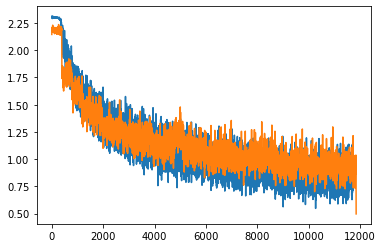

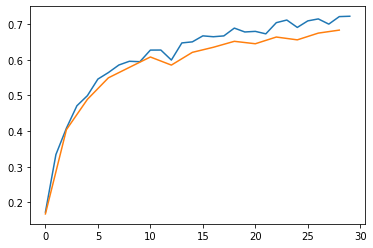

In [26]:
plt.figure()
plt.plot(train_loss_trace_tune)
plt.plot(range(0, 2370*5,5),test_loss_trace_tune)
plt.figure()
plt.plot(train_trace_tune)
plt.plot(range(0, 30, 2), test_trace_tune)
plt.show()

## Part G: Final Step!

Now that we've seen how well even simple CNNs can perform at image classification, let's go back and use our trained models to understand what convolutional layers are doing to help classify images. 

In this step you'll need to take a single image and pass it through just the first convolutional layer in your _trained_ network. 
The input to your first convolutional layer should have dimensions $1 \times 3 \times 32 \times 32$ and the output should have dimensions $1 \times 8 \times 30 \times 30$. 

Now, take your output and make a figure containing $9$ subplots in a $3 \times 3$ grid. The first entry in the subplot should be the image you passed through your convolutional layer, and the $8$ remaining subplots should contain each of the channels output by your convolutional layer as $30\times 30$ images.

You should see that each of the channels output by the convolutional filter highlights a different component of the input image - this behavior is central to the success of CNN! They are able to decompose the image into distinct features and use those features to classify images. Once you have your code working try generating your plot with different input images and see what patterns you can pick up on. Note that not all examples will look great, since the images are very low resolution. And congratulations on building and training your first neural networks!

**Hints:** If you have an $n \times m$ array you can plot it using the `plt.imshow` command, and if you have an $n \times m \times 3$ array, using this same command will generate a color plot where the last dimension is interepreted as the RGB channels. You will need to normalize your tensors so that their entries are in $[0, 1]$ for the plots to be rendered correctly.

Thus, to plot your input image which should be a torch tensor with dimensions $1 \times 3 \times 32 \times 32$, after you normalize it you can call:
```
plt.imshow(normalized_input[0].transpose(2, 1).transpose(0, 2))
```

**Answer Here**

In [27]:

for im, _ in trainloader:
  test_im = im
  break 



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [28]:
list(conv.children())[0][3]

Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))

In [29]:
def normalize_convolute(im):
  #Output normalized input image and convoluted output
  sd = [.5] 
  mean = [.5]
  normal_im = im * torch.Tensor(sd*3)[:, None, None] + torch.Tensor(mean*3)[:, None, None]
  normal_im = normal_im.transpose(0,2).transpose(0,1)
  im = torch.reshape(im, (1, 3, 32, 32)).to(device)
  output = list(conv.children())[0][0](im).squeeze().cpu()
  return normal_im.detach().numpy(), output.detach().numpy()




In [30]:
def display(im):
  #9x9 Grid with original output and convolution channels
  norm, output = normalize_convolute(im)
  fig, ax = plt.subplots(3,3, figsize=(10,10))
  
  ax[0,0].imshow(norm.squeeze())
  ax[0,1].imshow(output[0])
  ax[0,2].imshow(output[1])
  ax[1,0].imshow(output[2])
  ax[1,1].imshow(output[3])
  ax[1,2].imshow(output[4])
  ax[2,0].imshow(output[5])
  ax[2,1].imshow(output[6])
  ax[2,2].imshow(output[7])
  

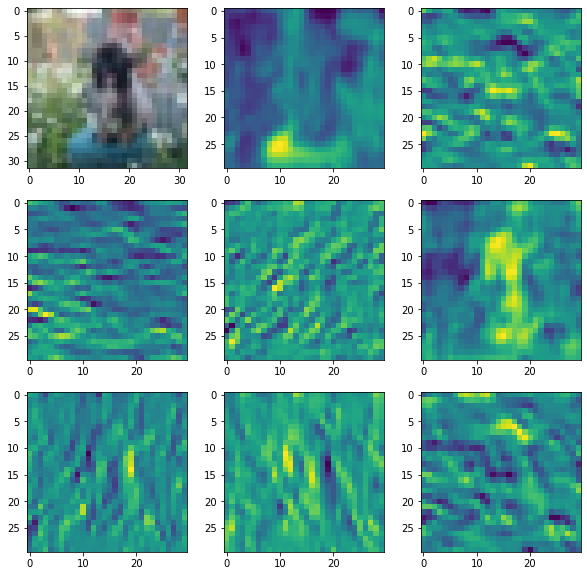

In [31]:
display(test_im[50])